
# Deeplearning Laboration

### Man kommer undersöka en förtränad CNN som fokuserar på bilder genom användning av Grad-CAM från Pytorch.

Undersökning kommer ske genom uppladdning av två bilder som kommer visualisera attribution för två lager alltså det tidiga och sena lagret. Sedan man vill resonera vad lager tittar på bilderna.

### Information om Grad-CAM

Grad-CAM kommer ge en så kallad attribution-karta alltså heatmap vilket kommer visa olika delar av bilden som kommer peka på modellens klassprediktion mest tack vare färgindikationer.

Grad‑CAM ger en attribution‑karta (heatmap) som visar vilka delar av bilden som påverkar modellens klassprediktion mest.

Man kommer se via den tidiga lager att den ska reagera på bildets mer allmänn kanter, kontraster och texturer.
När det gäller den sena lagret man kommer se att den reagerar mer på mer specifika deler såsom ansikte och päls på djur samt hjul och chassi på bilar m.m

In [12]:
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from torchcam.methods import GradCAM

Dags att implementera en funktion som ska förbereda bild för en förtränad model Resnet18, vilket valdes för att den är snabb för experimentera med skolarbete. Bilder blir konverterad så att det har korrekt storlek, omvandlat till tensor, med rätt dimensioner. så att modelen kan tolka de korrekt.

In [13]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    original_img = transforms.Resize((224, 224))(img)
    input_tensor = transform(img).unsqueeze(0)

    return input_tensor, original_img

Hämta modellen, aktivera den och ta reda på deras lager.

In [14]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()
print("Layers included:", [n for n, _ in model.named_children()])

Layers included: ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


Layer 1 motsvara den tidiga och Layer 4 den sena lagret.

In [15]:
layer_names = ["layer1", "layer4"]

## Bilder
### Bilder ska motsvara 2 husdjur
- Bild 1: Katt
- Bild 2: Hund 

Dags att skapa funktion som ska plota heatmap via gradcam på önskade lager.

In [16]:
def compare_layers_gradcam(model, input_tensor, original_img, layer_names):
    _, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i, layer in enumerate(layer_names):
        cam_extractor = GradCAM(model, target_layer=layer)

        outputs = model(input_tensor)
        class_idx = int(outputs.argmax(dim=1).item())

        cam = cam_extractor(class_idx, outputs)[0].squeeze()

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(original_img)
        axes[i, 1].imshow(cam, cmap="jet")
        axes[i, 1].set_title(f"Grad-CAM: {layer}")
        axes[i, 1].axis("off")

    plt.show()

### Testar bild 1: Katt
Använder Grad‑CAM för både layer 1 och layer 4 och jämför heatmaps.

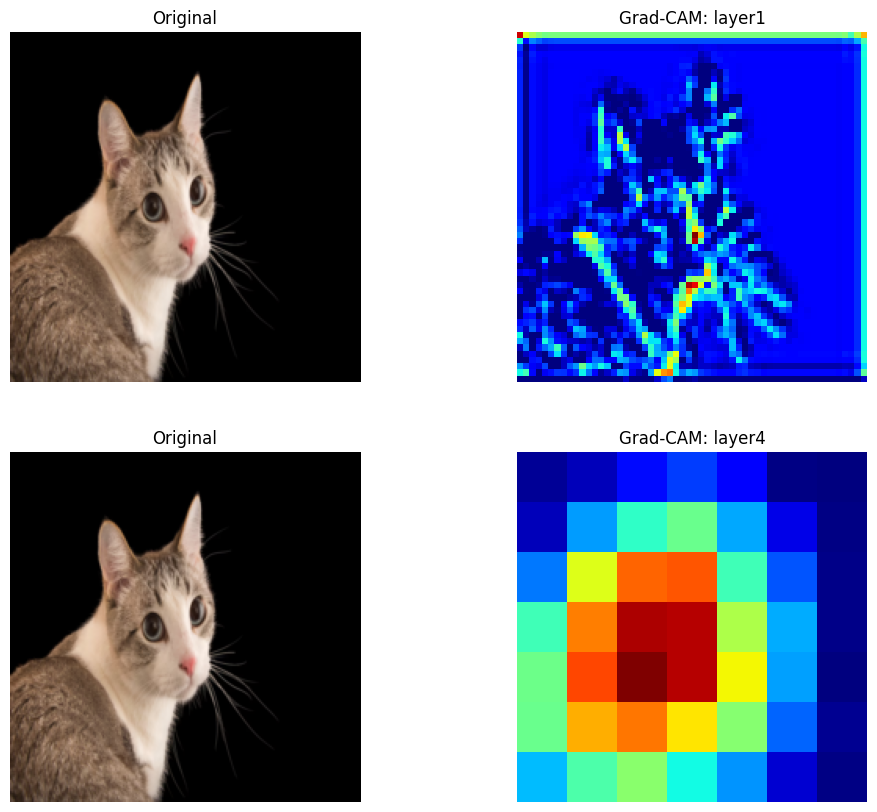

In [17]:
image1_path = "cat.jpg"

input_tensor1, original_img1 = load_and_preprocess_image(image1_path)
compare_layers_gradcam(
    model, input_tensor1, original_img1,
    layer_names=layer_names
)

Testar ifall om Klassnamn enligt ImageNet klasser som Resnet18 identifiering blir korrekt.

In [21]:
import urllib.request
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
with urllib.request.urlopen(labels_url) as f:
    labels = [line.strip() for line in f.readlines()]

outputs = model(input_tensor1)
class_idx = int(outputs.argmax(dim=1).item())
print(f"Prediction: {labels[class_idx].decode('utf-8')}")

Prediction: Egyptian cat


Modellen identfierade att det är katt.

### Testar bild 2: Hund
Använder Grad‑CAM för både lager 1 och layer 4 och jämför heatmaps.

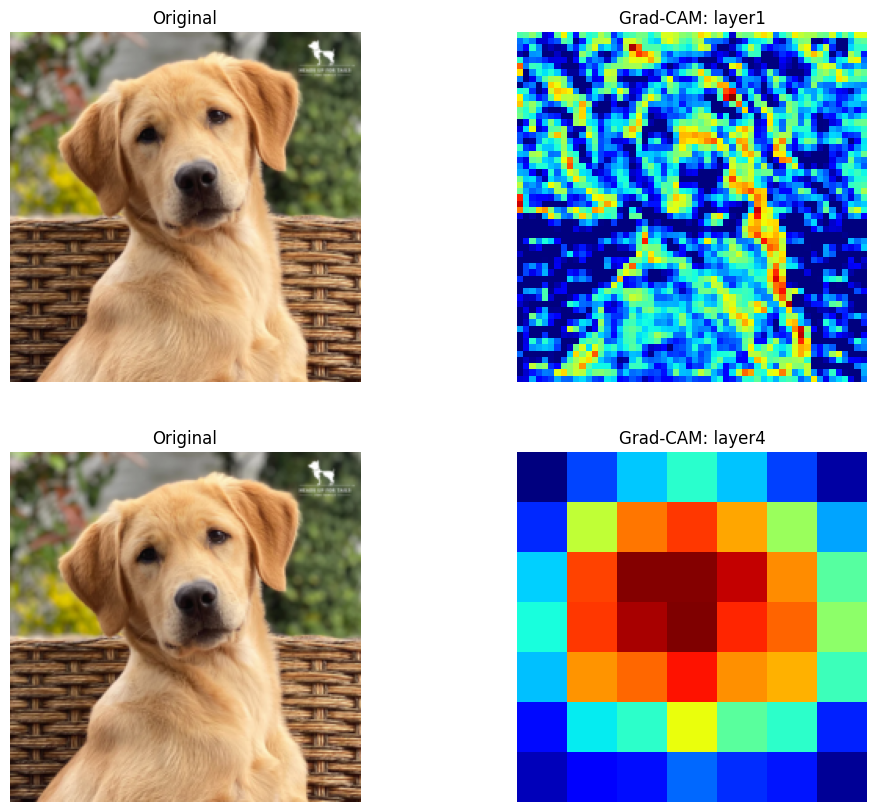

In [19]:
image2_path = "dog.jpg"

input_tensor2, original_img2 = load_and_preprocess_image(image2_path)
compare_layers_gradcam(
    model, input_tensor2, original_img2,
    layer_names=layer_names
)

In [22]:
# Test för att se ifall om den kan gissa rätt klass för hundbilden
outputs2 = model(input_tensor2)
class_idx2 = int(outputs2.argmax(dim=1).item())
print(f"Prediction: {labels[class_idx2].decode('utf-8')}")

Prediction: Labrador retriever


Bilden blev igenkännd av modellen som korrekt djur tom hundens ras identifierades.

## Avslutning

Kattbilden: Layer 1 verkar som ge mer utspridd aktivering såsom på kanter och texturer medan Layer 4 är mer fokused på själva katten verkar som huvud, ansikte lite på kroppen. 

Hundbilden: Layer 1 verkar vara mer generell och spridd på texturer och Layer 4 likt som för katten alltså hundens huvud och ansikte men verkar som kroppen blev inte identifierad här .

Eftersom båda är djur så är de tränad på liknande mönster för att identifera klassen som tillhör den förtrännade modellen. lager 1 features såsom texturer på bilder och lager 4 detaljer på objektet i detta fall ansikte på djuren för att identifiera de. Möjligtvis Labrador retriever klassen blev lite förvirrad med bakgrunden på bilden ändå lyckades den indentifiera bilden.

Begränsningar som finns är möjlightviss att bakgrund aktiveras pga dess mönsten kan korrelerar med klassen i träningsdata för inhämtad Resnet18. Kanske klassen har blivit tränad med bilder med bakgrunds mönster så att delvis aktiveras.